This is version 4 of the notebook with only the relevent analyses.

# TODO
- ADD THOSE DATA POINTS
- dendrogram: which groups are closest
- try kernel PCA?

# NOTES
- What's Stefano's formula for PCA? (we have different var exp)


# DATA INFO
- In mouse number the first digit is the cage number

In [19]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from vacou import *
from plots import *
from sklearn.metrics.pairwise import pairwise_distances

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set(font="monospace")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_fp = '/P/vacou/data/SS31_gait_data_for_PCA.tsv'
sep_runs_data_fp = '/P/vacou/data/all_separate_runs.csv'
#d_orig = pd.read_csv(data_fp, sep='\t')
response_column = 'Group'

In [99]:
# actual data
d, md, full_df = preprocess_vc(data_fp = data_fp, version = 2, use_vars_fp='data/use_variables.csv')

In [85]:
# actual data merged with separate run data
d, md, full_df = preprocess_vc(version= 4, data_fp=data_fp,
                               sep_runs_data_fp=sep_runs_data_fp,
                               use_vars_fp='data/use_variables.csv')

# Exploratory

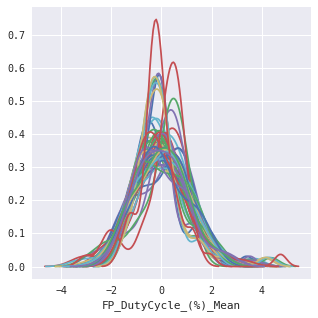

In [102]:
d = normalize_pd(d, axis=0)
d = scale_pd(d, axis=0)

fig, ax = plt.subplots(figsize=(5,5))
for c in d:
    sns.distplot(d[c], hist=False)

# PCA

In [103]:
comps, exvar, _ = get_pc(d)
comps.to_csv('data/PCs.tsv', sep='\t')

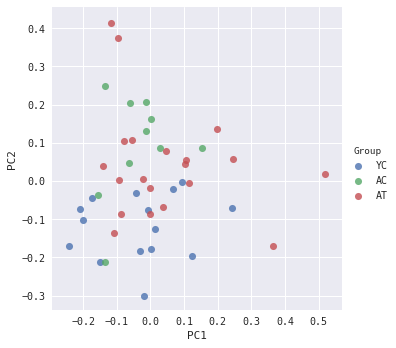

In [104]:
plot_comps = get_plot_comps(comps, md)
p2 = sns.lmplot(x='PC1', y='PC2', hue='Group', data=plot_comps, ci=None, fit_reg=False,
               scatter_kws={"s":50})

In [105]:
print('Variance explained')
pd.DataFrame(exvar).T

Variance explained


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
0,0.396307,0.205094,0.093443,0.071378,0.046853,0.035171,0.028655,0.024009,0.019564,0.011621,...,0.000086,0.000064,0.000057,0.000036,0.000013,0.000008,0.000005,0.000003,0.000001,4.910674e-31


# Differences between groups

### Is there any difference between all groups? Comparison with multiple variables for first three principal components. 

If the global multivariate test is significant, we conclude that the corresponding effect (treatment; here: group) is significant.

In [106]:
[print(i.rstrip()) for i in manovaR()['summary']];

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      2 0.54235   5.0849      6     82 0.0001759 ***
Residuals 42
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**RESULTS**: There seems to be a significant global difference between groups as assessed from the first three principal components.

The next question is to determine if which of the variables does the treatment affect. In other words, we want to identify the specific dependent variables that contributed to the significant global effect. To answer this question, we can use one-way ANOVA (or univariate ANOVA) to examine separately each dependent variable.

### Which variables differ between groups?

In [107]:
selected_a, x = sel_anova(d, md[response_column], mode = 'classif')

In [108]:
print("Features selected by f_regression")
selected_a.ix[selected_a.pval < 0.01]

Features selected by f_regression


,param,pval
14,LH_StrideLength_(cm)_Mean,1.694232e-08
42,FP_StrideLength_(cm)_Mean,4.252189e-08
7,LF_StrideLength_(cm)_Mean,5.135803e-08
58,RF_StrideLength_(cm)_Mean,6.048009e-08
22,RH_StrideLength_(cm)_Mean,6.621908e-08
12,RH_SingleStance_(s)_Mean,3.135726e-04
0,LH_SingleStance_(s)_Mean,5.463307e-04
27,LH_Swing_(s)_Mean,7.445412e-04
60,FP_SingleStance_(s)_Mean,1.429108e-03
49,RF_SingleStance_(s)_Mean,1.790273e-03


**RESULTS**: Above variables differ with significance level of 0.01.

### Is there a difference between any two groups? Comparison with multiple variables - MANOVA. 

In [109]:
set(comps.index.get_level_values('Group'))

{'AC', 'AT', 'YC'}

In [110]:
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary']];
print('\n------\n In which PCA axis do they differ most?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'AT'])['summary.aov']];

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df Pr(>F)
Group      1 0.10733    1.042      3     26 0.3905
Residuals 28

------
 In which PCA axis do they differ most?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.04901 0.049008  2.0922 0.1592
Residuals   28 0.65587 0.023424

 Response PC2 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.01633 0.016333  0.8105 0.3757
Residuals   28 0.56426 0.020152

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.01139 0.011387  0.5086 0.4817
Residuals   28 0.62690 0.022389



In [111]:
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary']];
print('\n------\n In which PCA axis do they differ most?\n')
[print(i.rstrip()) for i in manovaR(groups = ['AC', 'YC'])['summary.aov']];

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      1 0.57933   9.6401      3     21 0.0003343 ***
Residuals 23
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 In which PCA axis do they differ most?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq   Mean Sq F value Pr(>F)
Group        1 0.00008 0.0000799  0.0053 0.9424
Residuals   23 0.34406 0.0149589

 Response PC2 :
            Df  Sum Sq  Mean Sq F value    Pr(>F)
Group        1 0.26855 0.268552  23.067 7.611e-05 ***
Residuals   23 0.26777 0.011642
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.03950 0.039498  1.6001 0.2185
Residuals   23 0.56773 0.024684



In [112]:
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary']];
print('\n------\n In which PCA axis do they differ most?\n')
[print(i.rstrip()) for i in manovaR(groups = ['YC', 'AT'])['summary.aov']];

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

          Df  Pillai approx F num Df den Df    Pr(>F)
Group      1 0.51272   10.873      3     31 4.847e-05 ***
Residuals 33
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------
 In which PCA axis do they differ most?

ma <- manova(cbind(PC1, PC2, PC3)~ Group, data=data)

 Response PC1 :
            Df  Sum Sq  Mean Sq F value Pr(>F)
Group        1 0.05776 0.057761  2.2563 0.1426
Residuals   33 0.84479 0.025600

 Response PC2 :
            Df  Sum Sq  Mean Sq F value    Pr(>F)
Group        1 0.22513 0.225131   14.93 0.0004942 ***
Residuals   33 0.49760 0.015079
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Response PC3 :
            Df  Sum Sq  Mean Sq F value   Pr(>F)
Group        1 0.12855 0.128550  7.7648 0.008764 **
Residuals   33 0.54633 0.016555
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

